# **The Project Report**

---

## **1. Data Extraction:**
In this project, we utilized the **BeautifulSoup** library in conjunction with the **requests** library in Python to perform web scraping. Our objective was to gather detailed information about watches from the **Raymond Weil** website. The functionality of these libraries enabled us to efficiently navigate through the website's structure, retrieve URLs for various watch models, and extract pertinent details such as specifications, pricing, and availability for subsequent analysis.

## **2. Data Overview:**
The data collected is organized into a structured format with 40 distinct columns, each representing a specific attribute of the watches such as reference number, brand, type, case material, dial color, movement type, price, and many others. The dataset primarily focuses on a diverse range of watches, capturing essential details for both men's and women's collections. This comprehensive dataset serves as a foundational element for deeper analysis aimed at understanding market trends and product positioning.

## **3. Data Cleaning and Preprocessing:**
Upon retrieving the data, several preprocessing steps were necessary to ensure data quality and usability. This included standardizing text formats, correcting anomalies in numerical data, and addressing missing values where applicable. Regular expressions and custom functions were employed to clean and format the data, particularly in the price and reference number fields, to maintain consistency across the dataset.

## **4. Challenges:**
Throughout the data collection and analysis process, we encountered multiple challenges:

- **Case Sensitivity Issues:** Our dataset exhibited inconsistencies in text data due to case sensitivity, particularly evident in categorical fields such as "type", where variants like "Gents" and "gents" were treated as separate categories due to case differences. This required additional cleaning steps to unify similar terms and reduce redundancy.
  
- **Data Completeness:** Certain desired details such as the 'year introduced' were frequently unavailable, leading to gaps in our dataset. This absence of data limited some aspects of our temporal analysis, which could have provided insights into trends over time.
  
- **Pagination Handling:** The web scraping process involved managing pagination to access all available products. The website’s dynamic nature required adaptive techniques to ensure comprehensive data extraction across multiple pages.

## **5. Visualization and Analysis:**
For visual analysis, we employed libraries such as **Matplotlib** and **Seaborn** to create various visual representations of the data. These visualizations helped in identifying trends, outliers, and patterns in the watch characteristics, such as price distributions and popularity of certain models or features.

## **Conclusion:**
This project demonstrated the practical application of web scraping in gathering real-time market data and emphasized the importance of thorough data cleaning and preprocessing to enable effective data analysis. Future work could explore automated periodic data updates to keep the dataset current, and expanded analysis including predictive models to forecast market trends based on historical data.

---


## **1. Import Libraries:**

Here we import necessary Python libraries such as `requests` for handling HTTP requests, `BeautifulSoup` from `bs4` for parsing HTML and XML documents, and other supportive libraries like `datetime`, `time`, `csv`, and `re` for regular expressions.


In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import warnings
import time
import csv
import re

##**2. Define URL Scraping Function**
bold textThis function, `scrape_watch_urls`, takes a list of section URLs and iteratively scrapes each page for watch URLs. It navigates through pagination and collects all unique watch links available on the website using BeautifulSoup to parse HTML content.


In [2]:
def scrape_watch_urls(sections):
    """
    Scrapes all watch URLs from the provided sections of a website.

    Each section URL is paginated, and this function iterates through all pages of each section,
    extracting watch URLs until there are no more pages left to scrape.

    Args:
        sections (list): List of URLs of the sections to scrape.

    Returns:
        list: List of watch URLs.
    """

    # Initialize an empty list to store all watch URLs from all sections
    all_watch_urls = []

    # Loop through each section URL provided in the sections list
    for section_url in sections:
        current_page = 1  # Start scraping from the first page

        # Continuously process until there are no more pages
        while True:
            # Construct the paginated URL for the current page
            paginated_url = f"{section_url}page/{current_page}/"

            # Make a request to the paginated URL
            response = requests.get(paginated_url)

            # Break the loop if the page doesn't load successfully (e.g., 404, 500 errors)
            if response.status_code != 200:
                break

            # Parse the content of the page with BeautifulSoup
            soup = BeautifulSoup(response.content, 'html.parser')

            # Select all watch links on the current page
            watch_links = soup.select("a.woocommerce-LoopProduct-link.woocommerce-loop-product__link")

            # Extract the 'href' attribute from each link tag to get the watch URLs
            section_watch_urls = [link['href'] for link in watch_links]

            # Extend the main list with the URLs collected from the current page
            all_watch_urls.extend(section_watch_urls)

            # Try to find pagination links to determine if there are more pages to process
            pagination_links = soup.select("ul.page-numbers a.page-numbers")

            # Break the loop if no pagination links are found or if the last page has been reached
            if not pagination_links or current_page >= len(pagination_links):
                break
            else:
                # Move to the next page
                current_page += 1

    # Return the complete list of watch URLs collected from all sections
    return all_watch_urls


## **3. Define Watch Details Extraction Function**
The `extract_watch_details` function retrieves detailed information for each watch URL. It extracts fields such as the brand, model, price, and specifications from the product page. Data is cleaned and formatted appropriately before saving.


In [3]:
def extract_watch_details(url):
    """
    Retrieves detailed information for a specific watch URL.

    Args:
        url (str): URL of the watch product page to scrape.

    Returns:
        dict: Dictionary containing key-value pairs of watch attributes.
    """

    # Initialize dictionary to store watch details
    watch_data = {
        "watch_URL": url,
        "brand": "Raymond Weil",
        "currency": "USD",
        "made_in": "Switzerland",
         # Fields set to None because data is not available
        "year_introduced": None,
        "marketing_name": None,
        "style": None,
        "case_finish": None,
        "between_lugs": None,
        "lug_to_lug": None,
        "bezel_material": None,
        "bezel_color": None,
        "weight": None,
        "frequency":  None,
        "jewels":  None,
        "features":  None
    }

    response = requests.get(url)
    if response.status_code != 200:
        return {}  # Return empty if the page doesn't load successfully

    soup = BeautifulSoup(response.content, 'html.parser')

 # Extract parent_model
    watch_div = soup.find('div', class_='rwproduct__datas__tech__inner')
    if watch_div:
        watch_table = watch_div.find('table', class_='rwproduct__datas__tech__table')
        if watch_table:
            collection_element = watch_table.find('th', string='Collection')
            if collection_element:
                collection_td = collection_element.find_next('td')
                watch_data["parent_model"] = collection_td.text.strip() if collection_td else None

    # Extract reference_number
    ref_num_element = soup.find('div', class_="rwproduct__main__infos__sku")
    if ref_num_element:
        watch_data["reference_number"] = ref_num_element.get_text(strip=True)

    # Extract specific_model and nickname
    specific_model_element = soup.find('div', class_='rwproduct__main__infos__name').div
    if specific_model_element:
        watch_data["specific_model"] = specific_model_element.text.strip()
        watch_data["nickname"] = specific_model_element.text.strip()

    # Extract and format price
    price_element = soup.find('span', class_='woocommerce-Price-amount amount')
    if price_element:
        # Get the text of the price element
        price_text = price_element.get_text(strip=True)
        # Remove currency symbols and commas
        formatted_price = re.sub(r'[^\d.]', '', price_text)
        # Check if price ends with .00 and remove it, otherwise leave as is
        if formatted_price.endswith('.00'):
            formatted_price = formatted_price[:-3]
        # Remove any remaining trailing dots
        formatted_price = formatted_price.rstrip('.')
        # Save the formatted price into watch_data
        watch_data["price"] = formatted_price

    # Extract image_URL
    image_element = soup.select_one('.woocommerce-product-gallery__image img')
    if image_element and 'src' in image_element.attrs:
        watch_data["image_URL"] = image_element['src']

    # Extract type
    size_element = watch_table.find('th', string='Size').find_next('td')
    watch_data["type"] = size_element.text.strip() if size_element else None

    # Extract case_shape
    shape_element = watch_table.find('th', string='Shape')
    if shape_element:
        shape_td = shape_element.find_next('td')
        watch_data["case_shape"] = shape_td.text.strip() if shape_td else None

    # Extract case_material
    material_element = watch_table.find('th', string='Case material')
    if material_element:
        material_td = material_element.find_next('td')
        watch_data["case_material"] = material_td.text.strip() if material_td else None

    # Extract caseback
    caseback_element = watch_table.find('th', string='Case back')
    if caseback_element:
        caseback_td = caseback_element.find_next('td')
        watch_data["caseback"] = caseback_td.text.strip() if caseback_td else None

    # Extract diameter
    diameter_element = watch_table.find('th', string='Case size')
    if diameter_element:
        diameter_td = diameter_element.find_next('td')
        watch_data["diameter"] = diameter_td.text.strip() if diameter_td else None

    # Extract case_thickness
    case_thickness_element = watch_table.find('th', string='Case thickness')
    if case_thickness_element:
        case_thickness_td = case_thickness_element.find_next('td')
        watch_data["case_thickness"] = case_thickness_td.text.strip() if case_thickness_td else None

    # Extract crystal
    crystal_element = watch_table.find('th', string='Crystal')
    if crystal_element:
        crystal_td = crystal_element.find_next('td')
        watch_data["crystal"] = crystal_td.text.strip() if crystal_td else None

    # Extract water_resistance
    water_resistance_element = watch_table.find('th', string='Water resistance')
    if water_resistance_element:
        water_resistance_td = water_resistance_element.find_next('td')
        watch_data["water_resistance"] = water_resistance_td.text.strip() if water_resistance_td else None

    # Extract dial_color
    dial_color_element = watch_table.find('th', string='Dial')
    if dial_color_element:
        dial_color_td = dial_color_element.find_next('td')
        watch_data["dial_color"] = dial_color_td.text.strip() if dial_color_td else None

    # Extract numerals
    if dial_color_element:
        watch_data["numerals"] = dial_color_td.text.strip() if dial_color_td else None

    # Extract bracelet material
    bracelet_material_element = watch_table.find('th', string='Bracelet/Strap')
    if bracelet_material_element:
        bracelet_material_td = bracelet_material_element.find_next('td')
        watch_data["bracelet_material"] = bracelet_material_td.text.strip() if bracelet_material_td else None

    # Extract bracelet_color
    bracelet_color_element = bracelet_material_element
    if bracelet_color_element:
        bracelet_color_td = bracelet_color_element.find_next('td')
        watch_data["bracelet_color"] = bracelet_color_td.text.strip() if bracelet_color_td else None

    # Extract clasp_type
    clasp_type_element = watch_table.find('th', string='Clasp')
    if clasp_type_element:
        clasp_type_td = clasp_type_element.find_next('td')
        watch_data["clasp_type"] = clasp_type_td.text.strip() if clasp_type_td else None

    # Extract movement and caliber
    movement_element = watch_table.find('th', string='Movement')
    if movement_element:
        movement_td = movement_element.find_next('td')
        watch_data["movement"] = movement_td.text.strip() if movement_td else None
        watch_data["caliber"] = movement_td.text.strip() if movement_td else None

    # Extract power_reserve
    power_reserve_element = watch_table.find('th', string='Power reserve')
    if power_reserve_element:
        power_reserve_td = power_reserve_element.find_next('td')
        watch_data["power_reserve"] = power_reserve_td.text.strip() if power_reserve_td else None

    # Extract description
    description_element = soup.select_one('.rwproduct__datas__description__inner')
    if description_element:
        watch_data["description"] = "\n".join(p.text.strip() for p in description_element.find_all('p')) if description_element else None

    # Extract short description
    # First, attempt to extract from a span with data-sheets-value attribute
    short_description_element = soup.select_one('.rwproduct__main__infos__name span[data-sheets-value]')
    if not short_description_element:
        # If not found in span, try finding the text in the second <p> tag
        short_description_element = soup.select_one('.rwproduct__main__infos__name p:nth-of-type(2)')

    if short_description_element:
        # Check if the element has 'data-sheets-value' attribute to determine how to extract text
        if 'data-sheets-value' in short_description_element.attrs:
            contents = short_description_element.contents
            short_description_text = ''.join(str(content) for content in contents if content and str(content).strip())
        else:
            short_description_text = short_description_element.text.strip()
        watch_data["short_description"] = short_description_text
    else:
        watch_data["short_description"] = None

    return watch_data


## **4. Execute Scraping**
In this section, we define the main sections of the website to be scraped and execute the `scrape_watch_urls` function to collect all watch URLs from these sections. The collected URLs are then printed out to verify the scraping process.


In [4]:
# Define a list of URLs to be scraped
sections = [
    "https://www.raymond-weil.us/collections/for-him/",
    "https://www.raymond-weil.us/collections/for-her/"
]

# Call the function `scrape_watch_urls` with the list of section URLs
# This function is designed to navigate through each given section URL, scrape all the watch URLs,
# and return them as a list
all_watch_urls = scrape_watch_urls(sections)

# Print the number of watch URLs collected to the console
print(f"Collected {len(all_watch_urls)} watch URLs:")

# Iterate through each URL in the list of all collected watch URLs
for url in all_watch_urls:
    print(url)  # Print each watch URL to the console


Collected 156 watch URLs:
https://www.raymond-weil.us/product/freelancer-7741-sc7-52021/
https://www.raymond-weil.us/product/freelancer-diver-mens-two-tone-gradient-blue-dial-bracelet-watch-425-mm/
https://www.raymond-weil.us/product/freelancer-2731-stp-65001/
https://www.raymond-weil.us/product/toccata-mens-classic-white-dial-leather-quartz-watch-39mm/
https://www.raymond-weil.us/product/toccata-mens-classic-gold-pvd-white-dial-quartz-watch-39mm/
https://www.raymond-weil.us/product/millesime-mens-automatic-small-seconds-watch-39-5-mm/
https://www.raymond-weil.us/product/millesime-mens-automatic-blue-leather-strap-watch-39-5-mm/
https://www.raymond-weil.us/product/millesime-mens-automatic-pink-sector-dial-watch-39-5-mm/
https://www.raymond-weil.us/product/toccata-5485-sl5-65001/
https://www.raymond-weil.us/product/toccata-mens-classic-rectangular-gold-pvd-white-dial-leather-watch-37-x-29-mm/
https://www.raymond-weil.us/product/toccata-mens-classic-rectangular-stainless-steel-watch-37-x

## **5. Execute Scraping**
In this section, we define the main sections of the website to be scraped and execute the `scrape_watch_urls` function to collect all watch URLs from these sections. The collected URLs are then printed out to verify the scraping process.


In [5]:
# Get the current date and time for a unique file name every time the script runs
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M")

# Constructing a file name: 'RaymondWeil_WatchData_YYYY-MM-DD_HH-MM.csv'
csv_file = f"RaymondWeil_WatchData_{timestamp}.csv"
csv_columns = [
    "reference_number", "watch_URL", "type", "brand", "year_introduced",
    "parent_model", "specific_model", "nickname", "marketing_name", "style",
    "currency", "price", "image_URL", "made_in", "case_shape",
    "case_material", "case_finish", "caseback", "diameter", "between_lugs",
    "lug_to_lug", "case_thickness", "bezel_material", "bezel_color", "crystal",
    "water_resistance", "weight", "dial_color", "numerals", "bracelet_material",
    "bracelet_color", "clasp_type", "movement", "caliber", "power_reserve",
    "frequency", "jewels", "features", "description", "short_description"
]

# Write the extracted details to the CSV file
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for url in all_watch_urls:
        watch_details = extract_watch_details(url)
        writer.writerow(watch_details)



## 8- Data Visualization
Below are visualizations that highlight key details and data quality of the watch collection.






---

### 8.1- Count of Watches by Type:

<ipython-input-6-a756cbafafd6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='type', palette=light_colors)
<ipython-input-6-a756cbafafd6>:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.countplot(data=df, x='type', palette=light_colors)


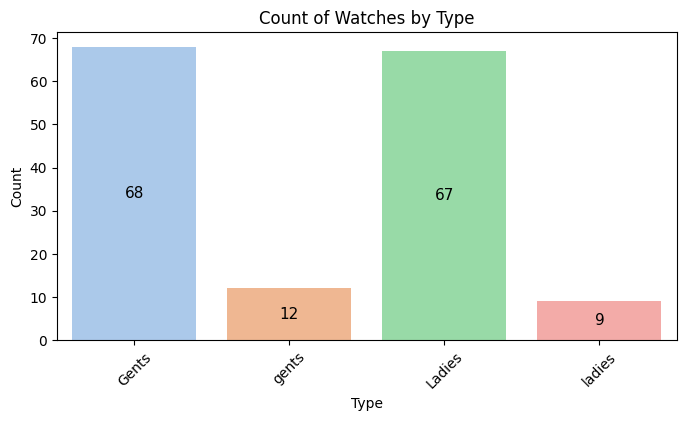

In [6]:
df = pd.read_csv(csv_file)

light_colors = sns.color_palette("pastel")

plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df, x='type', palette=light_colors)
plt.title('Count of Watches by Type')
plt.xticks(rotation=45)
plt.xlabel('Type')
plt.ylabel('Count')

for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_height() / 2
    value = int(p.get_height())
    ax.text(_x, _y, value, ha="center", va="center", fontsize=11, color='black')
plt.show()

### 8.2- Count of Watches by Parent Model:







<ipython-input-7-38cda0b081cf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y='parent_model', palette=light_colors, order=df['parent_model'].value_counts().index)
<ipython-input-7-38cda0b081cf>:3: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  ax = sns.countplot(data=df, y='parent_model', palette=light_colors, order=df['parent_model'].value_counts().index)


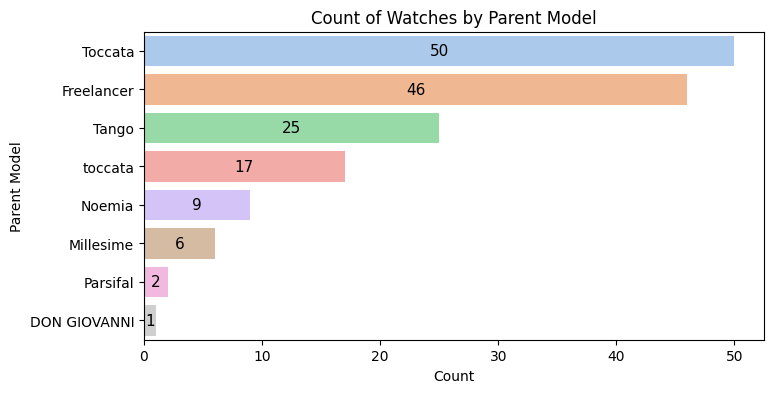

In [7]:
light_colors = sns.color_palette("pastel")
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df, y='parent_model', palette=light_colors, order=df['parent_model'].value_counts().index)
plt.title('Count of Watches by Parent Model')
plt.xlabel('Count')
plt.ylabel('Parent Model')

for p in ax.patches:
    bar_width = p.get_width()
    ax.annotate(f'{int(bar_width)}',
                xy=(bar_width / 2, p.get_y() + p.get_height() / 2),
                ha='center', va='center',
                fontsize=11, color='black',
                xytext=(0, 0),
                textcoords='offset points')
plt.show()

###8.3- Word Cloud from Short Descriptions:

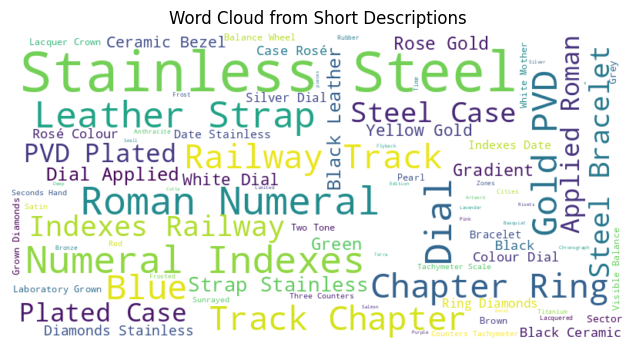

In [8]:
all_descriptions = ' '.join(df['short_description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_descriptions)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Short Descriptions')
plt.show()

###8.4- Top 10 Parent Models:






<ipython-input-10-3172934334c0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_parent_models.values, y=top_parent_models.index, palette='coolwarm')


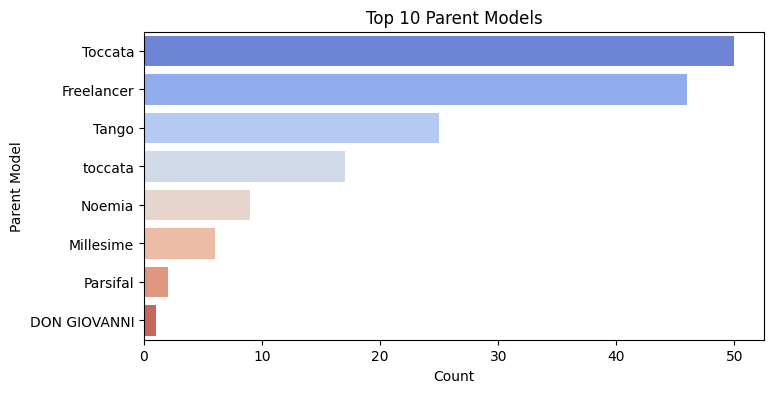

In [10]:
top_parent_models = df['parent_model'].value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_parent_models.values, y=top_parent_models.index, palette='coolwarm')
plt.title('Top 10 Parent Models')
plt.xlabel('Count')
plt.ylabel('Parent Model')
plt.show()

###8.5- Case Material Distribution:



<ipython-input-24-e3b2ac7a71a8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=case_material_dist.values, y=case_material_dist.index, palette='Spectral')


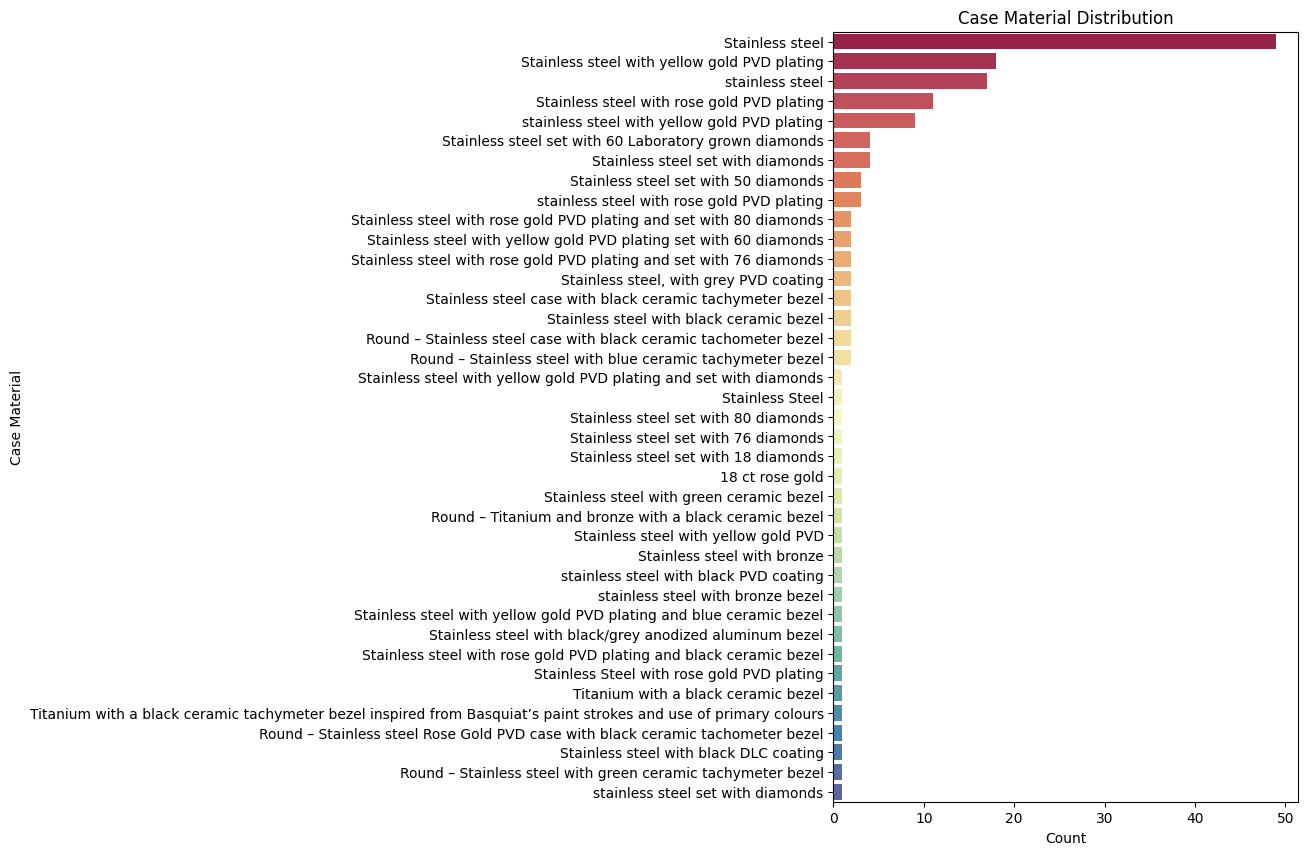

In [24]:
case_material_dist = df['case_material'].value_counts()
plt.figure(figsize=(6, 10))
sns.barplot(x=case_material_dist.values, y=case_material_dist.index, palette='Spectral')
plt.title('Case Material Distribution')
plt.xlabel('Count')
plt.ylabel('Case Material')
plt.show()

###8.6- Watch Movement Type Distribution:





<ipython-input-22-2dfe6d751d66>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movement_type_dist.values, y=movement_type_dist.index, palette='rocket')


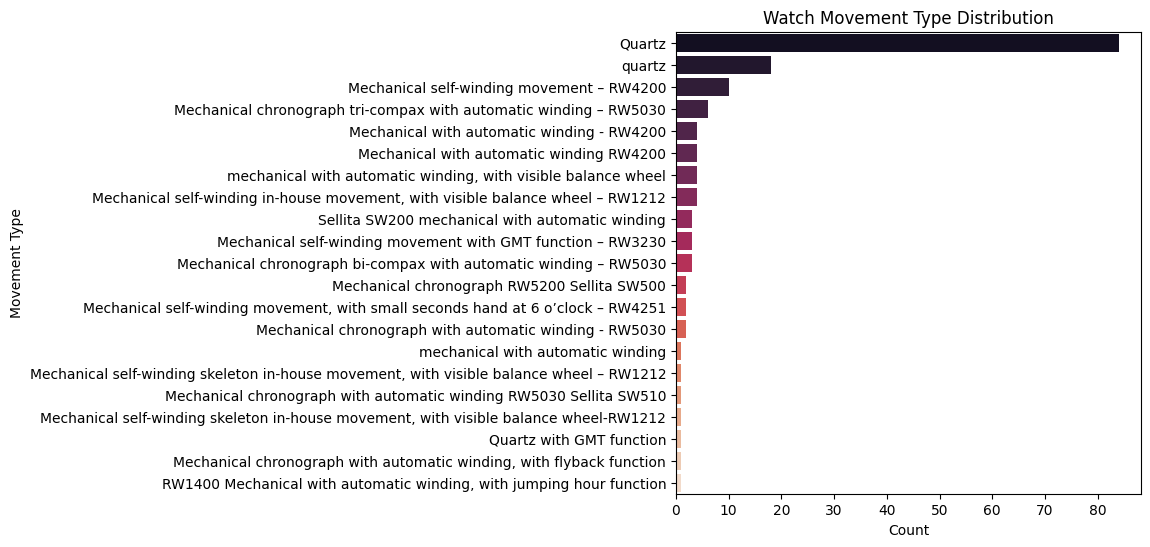

In [22]:
movement_type_dist = df['movement'].value_counts()
plt.figure(figsize=(6, 6))
sns.barplot(x=movement_type_dist.values, y=movement_type_dist.index, palette='rocket')
plt.title('Watch Movement Type Distribution')
plt.xlabel('Count')
plt.ylabel('Movement Type')
plt.show()

###8.7- Distribution of Case Diameter:





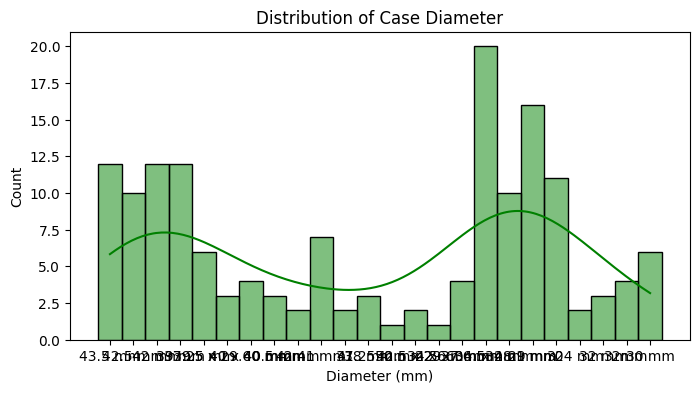

In [13]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='diameter', bins=15, kde=True, color='green')
plt.title('Distribution of Case Diameter')
plt.xlabel('Diameter (mm)')
plt.ylabel('Count')
plt.show()

###8.8- Water Resistance Distribution:





<ipython-input-14-c86443bac951>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=water_resistance_dist.values, y=water_resistance_dist.index, palette='muted')


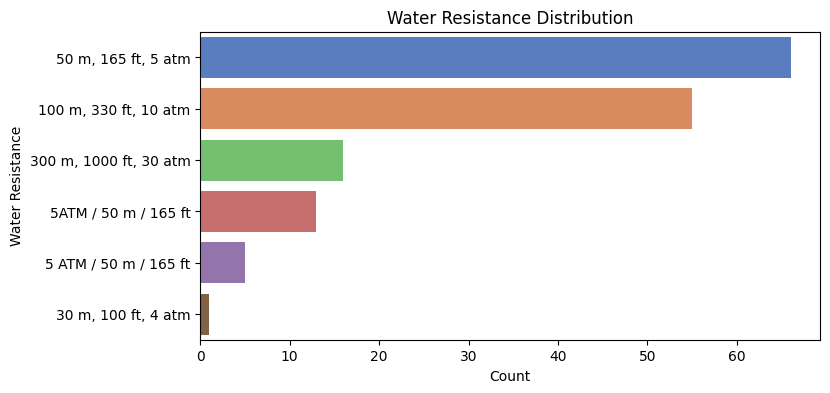

In [14]:
water_resistance_dist = df['water_resistance'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=water_resistance_dist.values, y=water_resistance_dist.index, palette='muted')
plt.title('Water Resistance Distribution')
plt.xlabel('Count')
plt.ylabel('Water Resistance')
plt.show()

###8.9- Top 10 Dial Colors:





<ipython-input-15-a21a817e0103>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dial_color_dist.values, y=dial_color_dist.index, palette='cubehelix')


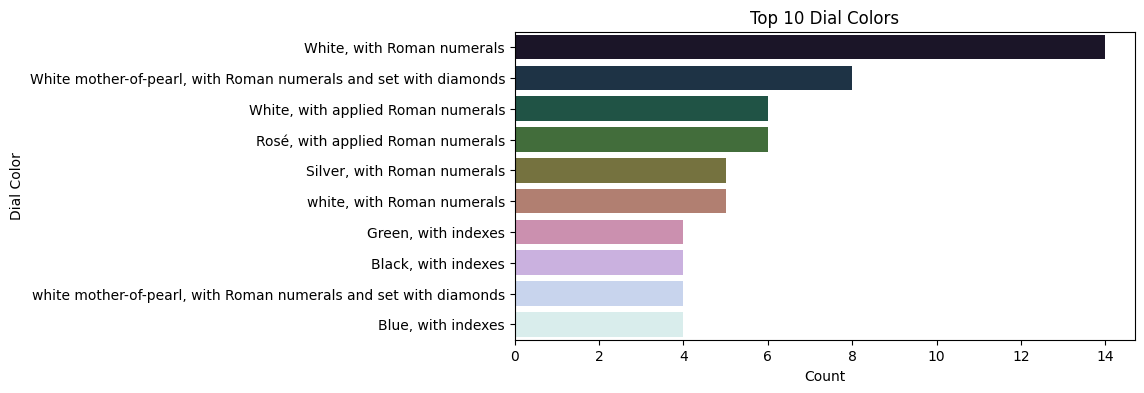

In [15]:
dial_color_dist = df['dial_color'].value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=dial_color_dist.values, y=dial_color_dist.index, palette='cubehelix')
plt.title('Top 10 Dial Colors')
plt.xlabel('Count')
plt.ylabel('Dial Color')
plt.show()

###8.10- Count of Missing Values in Each Column:





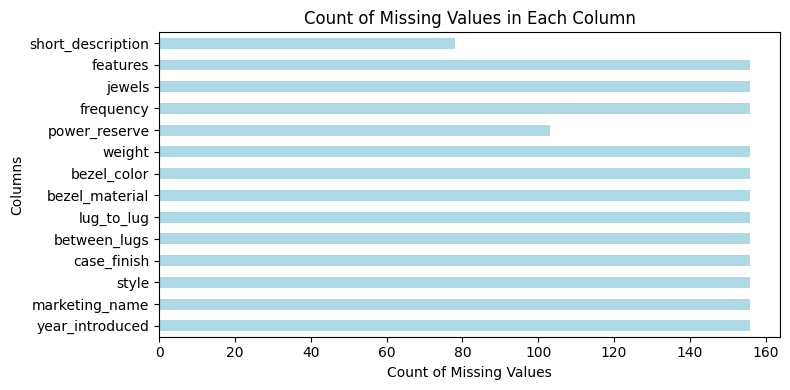

In [16]:
missing_values_count = df.isnull().sum()
missing_values_count = missing_values_count[missing_values_count > 0]
plt.figure(figsize=(8, 4))
missing_values_count.plot(kind='barh', color='lightblue')
plt.title('Count of Missing Values in Each Column')
plt.xlabel('Count of Missing Values')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()

###8.11- Count of Unique Values in Each Column:





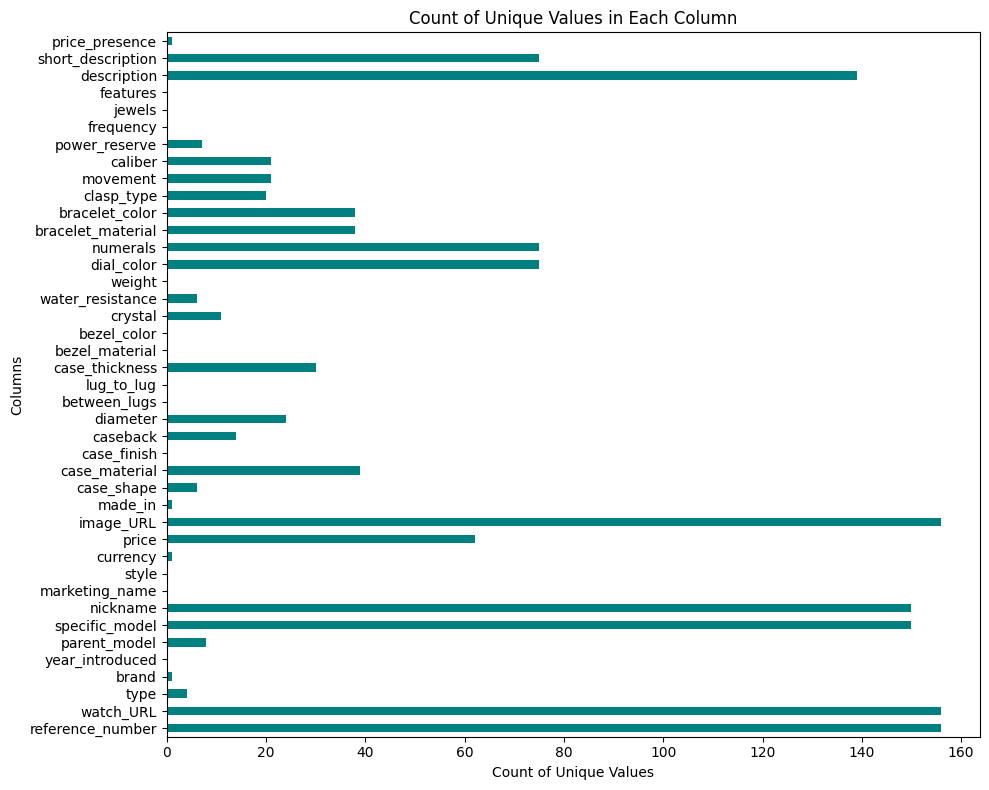

In [17]:
unique_values_count = df.nunique()
plt.figure(figsize=(10, 8))
unique_values_count.plot(kind='barh', color='teal')
plt.title('Count of Unique Values in Each Column')
plt.xlabel('Count of Unique Values')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()